In [48]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:ß
import numpy as np
# for matplotlib
from dsatools import decomposition
import pandas as pd

import matplotlib.pyplot as plt
from pydantic import BaseModel
import matplotlib.pyplot as plt
from glob import glob
import os

from typing import List

In [49]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

# def load_data(filenames:List[str], x_range:XRange=None, basepath:str="./data") -> np.array:
#     import os
#     spectrums = []
#     for f in filenames:
#         # print(f)
#         spectrum = _single_load_data(filename=f, x_range=x_range, basepath=basepath)
#         spectrums.append(spectrum)

#     # avergae
#     spectrums = np.array(spectrums)
#     spectrums = spectrums.mean(axis=0)
#     return spectrums

color_map = {
    0:"tab:blue",
    50:"tab:orange",
    100:"tab:green",
    150:"tab:red",
    200:"tab:purple",
    300:"tab:brown",
    400:"tab:pink",
    500:"tab:gray",
}

In [50]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parameters for this case:
lam = 10_000_000 # smoothness
p = 0.05 # asymmetry
# Baseline stimation function:
def baseline_als(y, lam, p, n_epoch=100) -> np.array:
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_epoch):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    corrected_y = y.copy() - z.copy()
    return corrected_y, z


In [51]:
sorted(glob(f"./data/*"))

['./data/0_600_785 nm_60 s_1_2024_03_26_00_13_25_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_14_27_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_15_29_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_16_32_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_17_35_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_18_37_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_19_40_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_20_42_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_21_45_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_26_00_22_54_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_23_39_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_24_44_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_25_50_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_26_54_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_27_55_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_42_17_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_25_23_43_21_01.txt',


In [52]:
glucoses = []
spectrums = []
files = sorted(glob(f"./data/*"))
x_range = XRange(lower_limit=900, higher_limit=1500)
for f in files:
    char = f[7]
    if(char not in ['0','1','2','5']):
        continue
    
    spectrum = load_data(filename=f, x_range=x_range, basepath="")
    spectrums.append(spectrum)
    filename = os.path.split(f)[1]
    glucose = filename.split("_")[0]
    glucoses.append(int(glucose))


In [53]:
noises = []
files = sorted(glob(f"./data/externalnoise*"))
x_range = XRange(lower_limit=900, higher_limit=1500)
for f in files:
    # char = f[7]
    # if(char not in ['0','1','2','5']):
    #     continue
    
    noise = load_data(filename=f, x_range=x_range, basepath="")
    noises.append(noise)


In [77]:
np.array(noises)[:,:,1]

(5, 306)

In [87]:
def lower_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * ratio)))
    return point

def higher_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * ratio)))
    return point

def standardized(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    # x_i = x_i - mean / std
    mean = x.mean()
    std = x.std()
    # print(mean, std)
    x = (x - mean)/std
    return x

def normalization(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    min = x.min()
    max = x.max()
    x = (x - min)/(max - min)
    return x
# normalization(y)

def butter_lowpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, y)
    return y

    glucoses  measures
4          0  0.227345
8          0  0.228941
6          0  0.229129
3          0  0.234132
23       150  0.234620
2          0  0.234666
1          0  0.235721
9          0  0.236871
0          0  0.236874
31       200  0.239072
26       150  0.239374
21       150  0.239514
32       200  0.239923
35       200  0.240899
7          0  0.241307
36       200  0.241576
5          0  0.241641
22       150  0.242213
34       200  0.242227
33       200  0.243278
39       200  0.244871
37       200  0.244881
24       150  0.246094
25       150  0.246138
27       150  0.246247
30       200  0.246277
18       100  0.247392
28       150  0.249159
38       200  0.249353
20       150  0.253264
29       150  0.255058
17       100  0.255444
15       100  0.257322
19       100  0.257835
40        50  0.258361
41        50  0.259028
16       100  0.259187
11       100  0.268255
43        50  0.270947
10       100  0.273554
42        50  0.274635
12       100  0.275934
44        5

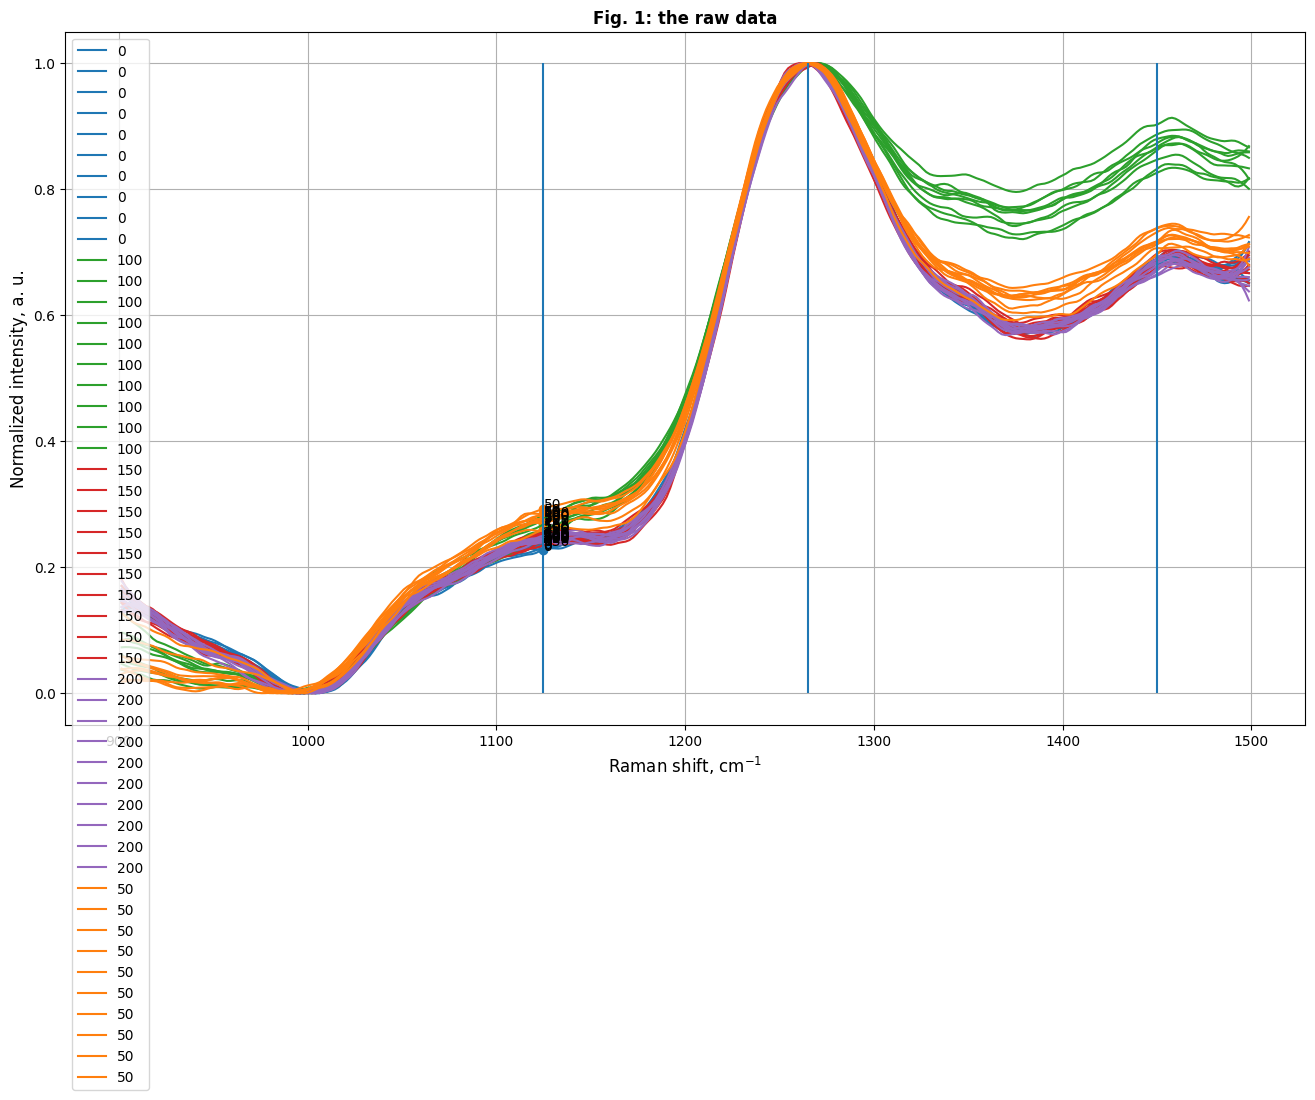

In [119]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[1000, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])

measures = []
# for idx in np.where( (np.array(glucoses) == 50) |  (np.array(glucoses) == 100) | (np.array(glucoses) == 150) )  [0]:
for idx in range(len(glucoses)):
    # print(idx)
    glucose = glucoses[idx]
    spectrum = spectrums[idx]
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=1)
    y = standardized(y)
    y = y + abs(y.min())
    # y = decomposition.hvd(y,order=2, fpar=15)[0]
    # y = decomposition.hvd(np.pad(y,(0,1)),order=2, fpar=15)[0]
    # y = np.delete(y, len(y)-1)
    # y = rp.smooth(x,y,method="savgol",window_length=7,polyorder=2)

    # y = y[:,0]
    # y, base_als = rp.baseline(x, y, roi1, 'als', lam=1e+5, p=1e-3)

    # y = rp.smooth(x,y,method="savgol",window_length=15,polyorder=1)

    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    # y, baseline = baseline_als(y, lam=1e+12, p=p)
    # y = normalization(y)
    # y = savgol_filter(y.copy(), window_length=15, polyorder=10, deriv=0)
    # y_1450 = y[(x > 1250) & (x < 1460)].mean()
    # y = y/y_1450
    y = y / y.max()
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    txt_pos_y = y[(x > 1120) & (x < 1130)][0]
    txt_pos_x = 1125
    measure = y[(x > 1120) & (x < 1130)].mean()
    # measure = y[(x > 900) & (x < 910)].mean()

    measures.append(measure)
    # print(glucose, measure)
    # ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    ax.text(x=txt_pos_x, y=measure, s=str(glucose))
    ax.scatter(x=txt_pos_x, y=measure,c=color_map[glucose])
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

data = {
    "glucoses": glucoses,
    "measures": measures
}
print(pd.DataFrame(data=data).sort_values("measures"))


ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
# ax.vlines(x=515, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
# ax.set_ylim(ymin=lower_thres(ymin_1125,0.01), ymax=higher_thres(ymax_1125,0.01) )
# ax.set_xlim(xmin=1000, xmax=1300)
ax.grid()
ax.legend()
plt.show()

In [56]:
data = {
    "glucoses": glucoses,
    "measures": measures
}
pd.DataFrame(data=data).sort_values("measures")

,glucoses,measures
49,50,2585.059914
48,50,2617.814274
47,50,2642.334783
46,50,2660.081043
45,50,2702.248134
44,50,2739.382140
43,50,2799.184287
42,50,2826.328448
41,50,2853.024246
14,100,2901.697126


In [57]:
def lower_thres(point:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * 0.01)))
    return point

def higher_thres(point:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * 0.01)))
    return point
higher_thres(10)

10.1

In [58]:
np.sign(-10)

-1

0.8174549656135586
0.8319810177946465
0.8341498351958602
0.8210955218675953
0.839755629724958
0.8059346745855961
0.825735779255034
0.8246815570724855
0.8313557942416011
0.8303496265984237
1.036436580071703
1.0308173130702285
1.0186903555057973
1.001815265458099
0.9829637645393128
1.063102451324007
1.0798344165459228
1.0644367781513686
1.0412474205526772
1.043062330890005
0.8297141222919723
0.808349883351262
0.8335588092701722
0.8076027024916065
0.8147665527518035
0.8263154275690604
0.8240302568907374
0.8399351855204024
0.810925051075045
0.8091371845559876
0.8180663418202034
0.8340359760913455
0.7865336492523457
0.8184801647483323
0.7718642790982077
0.7827276954602644
0.8065577322076094
0.7988979089056049
0.8463274851147973
0.8420696359525696
0.8414069133664757
0.8312715783174759
0.8512239371498235
0.8326971015885107
0.8609524559183416
0.8341222182150267
0.8200350259403467
0.8372717471040771
0.8736961583749298
0.8708586427585119


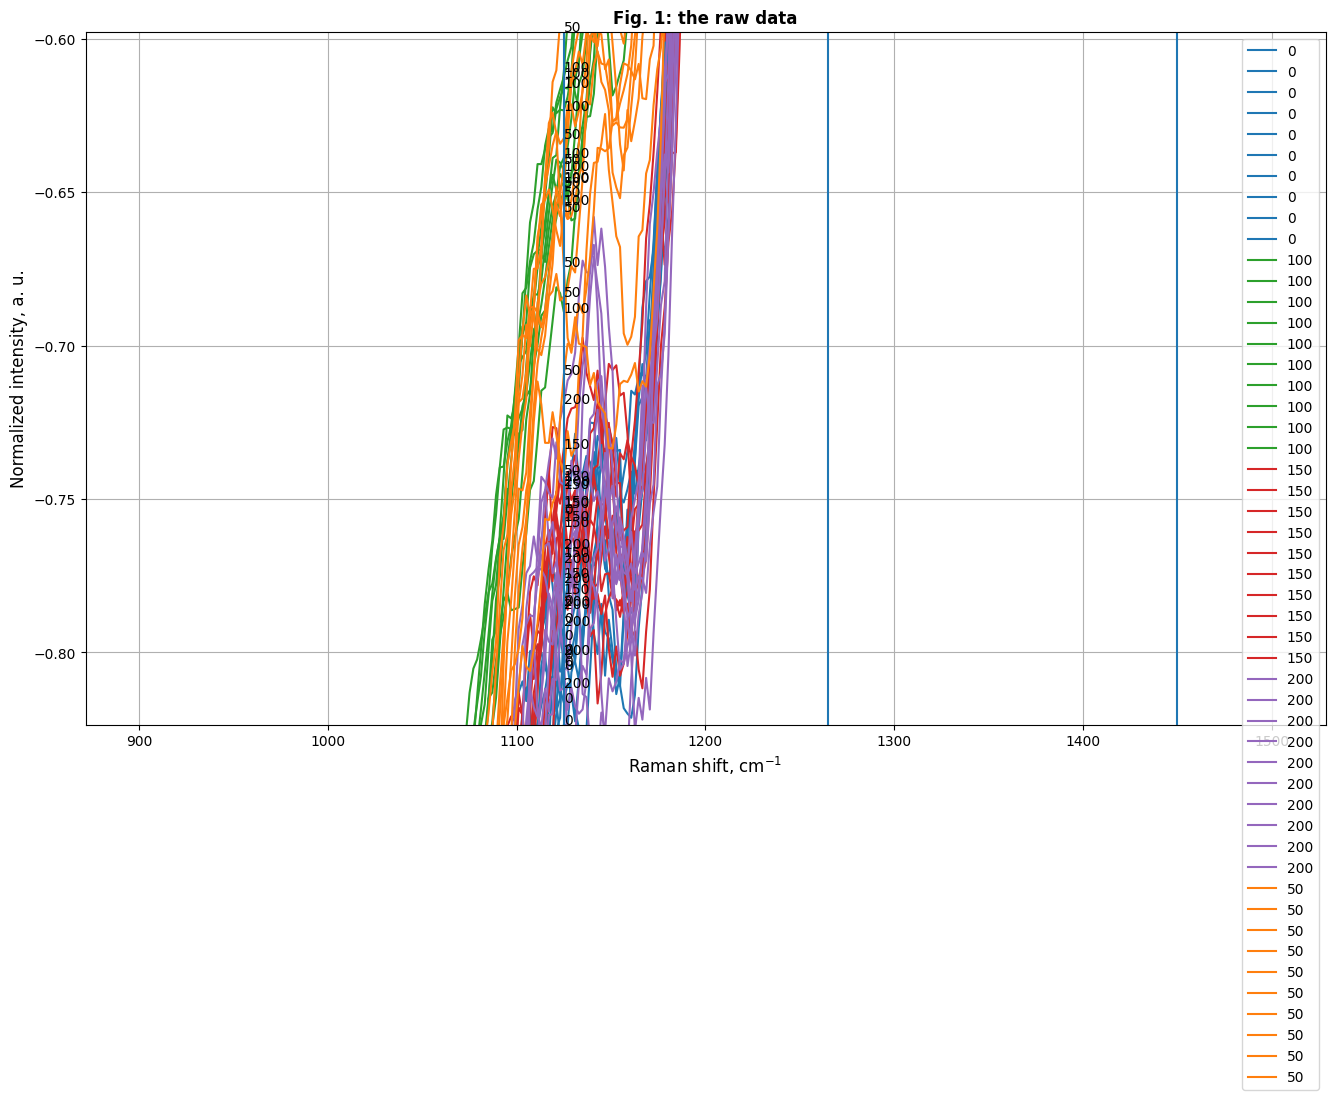

In [59]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)
    y = standardized(y)
    # y = normalization(y)
    # y, base_als = rp.baseline(x, y, roi2, 'als', lam=10**7, p=0.001) 
    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    y = savgol_filter(y.copy(), window_length=15, polyorder=2, deriv=0)
    y_1450 = y[(x > 1440) & (x < 1460)].mean()
    print(y_1450)
    y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=ymin_1125, ymax=ymax_1125)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()

163.00883307949823
136.82146980494463
142.04481650442665
133.76729005485325
182.50225376459863
156.70823513207233
147.39100210581256
150.47392021049185
179.6348121016917
146.68094457339313
256.24515970831504
220.75088916020647
251.32821053494246
274.2737836573229
227.73827117911395
222.00476617161155
266.0934696777738
242.33549965207004
226.20416034587603
243.64357244002775
133.02353244909816
147.44691060247422
156.899087685206
164.32903433055688
145.00093875623273
161.55153225733557
155.45653570055936
190.4566226679921
155.5398389795594
151.51976179924534
172.05094913189112
145.16588313136182
135.9034522458508
180.59343706169983
132.25257461879494
142.0460920856908
170.3111780578335
154.49087991157273
163.3789697008476
180.46943157351117
165.9527686144262
155.08967142097316
169.42780499440624
155.43823997619756
152.8310458062591
178.09561788278984
157.90806306372735
178.83562688566974
177.6038566203338
173.10248756605753


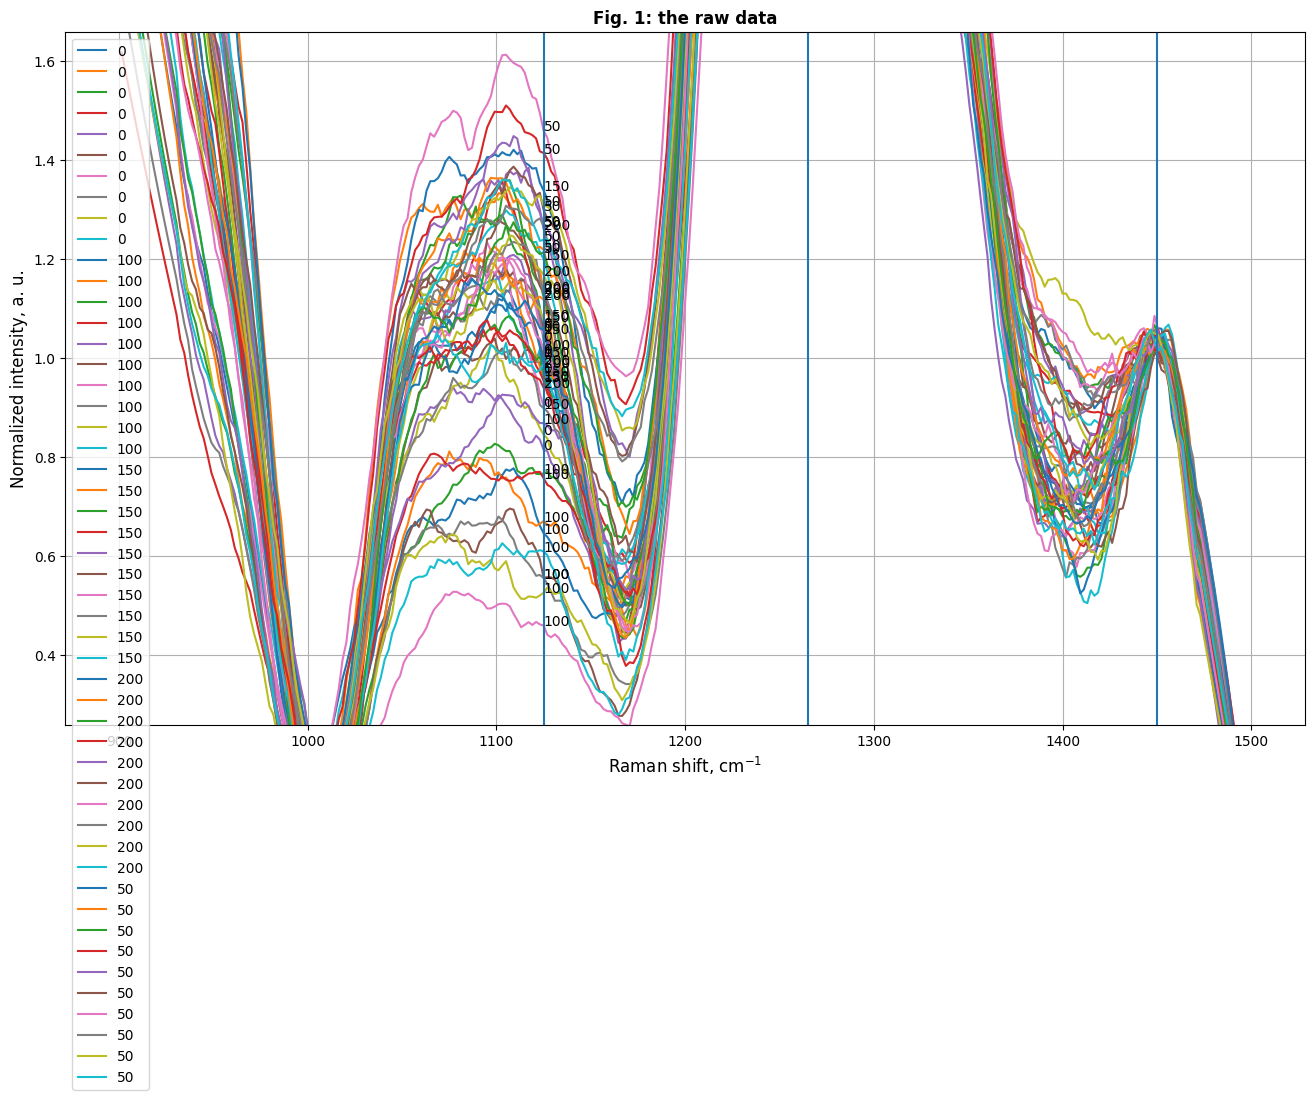

In [60]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)   
    y, base_als = rp.baseline(x, y, roi2, 'als', lam=10**7, p=0.001) 
    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    y = savgol_filter(y[:,0].copy(), window_length=30, polyorder=2, deriv=0)
    y_1450 = y[(x > 1440) & (x < 1460)].mean()
    print(y_1450)
    y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose)
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=ymin_1125-0.2, ymax=ymax_1125+0.2)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()